Accuracy on test set: 0.6330645161290323


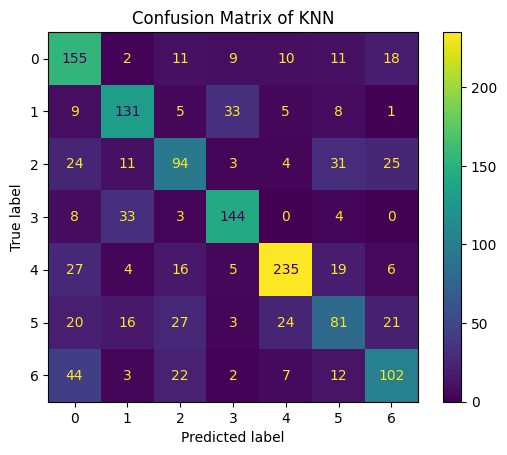

Accuracy on test set: 0.6189516129032258
Accuracy on test set: 0.6182795698924731
Accuracy on test set: 0.6129032258064516
Accuracy on test set: 0.6223118279569892
Best macro ROC and PR curves data saved successfully.


In [1]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature, io
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import random
from skimage.feature import graycomatrix, graycoprops

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed = 42
set_seed(seed)
IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png')

def is_image_file(filename):
    return filename.lower().endswith(IMG_EXTENSIONS)

def find_classes(dir):
    classes = [d.name for d in os.scandir(dir) if d.is_dir()]
    classes.sort()
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

def func(dir):
    classes, class_to_idx = find_classes(dir)
    imgs = []
    labels = []
    for target_class in sorted(class_to_idx.keys()):
        class_index = class_to_idx[target_class]
        target_dir = os.path.join(dir, target_class)
        if not os.path.isdir(target_dir):
            continue
        for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
            for fname in sorted(fnames):
                if is_image_file(fname):
                    path = os.path.join(root, fname)
                    imgs.append(path)
                    labels.append(class_index)
    return imgs, labels

def extract_glcm_features(image, distances=[5], angles=[0], levels=256, symmetric=True, normed=True):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    glcm = graycomatrix(gray, distances, angles, levels=levels, symmetric=symmetric, normed=normed)
    features = []
    properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
    for prop in properties:
        feature = graycoprops(glcm, prop)
        features.append(feature.flatten())
    return np.hstack(features)

def extract_features(image_paths):
    features = []
    for path in image_paths:
        image = io.imread(path)
        # Convert to RGB if the image is grayscale
        if len(image.shape) == 2:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        glcm_features = extract_glcm_features(image)
        features.append(glcm_features)
    return np.array(features)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)  
all_test_labels = []
all_test_predictions = []
all_test_probabilities = []

dir_train = "500/train"
dir_test = "500/test"
train_list = func(dir_train)
test_list = func(dir_test)

img = train_list[0] + test_list[0]
labels = train_list[1] + test_list[1]

best_accuracy = 0
best_fpr = None
best_tpr = None
best_roc_auc = None
best_precision = None
best_recall = None
best_pr_auc = None

for train_index, test_index in skf.split(img, labels):
    train_img_paths = [img[i] for i in train_index]
    test_img_paths = [img[i] for i in test_index]
    train_labels = [labels[i] for i in train_index]
    test_labels = [labels[i] for i in test_index]

    train_features = extract_features(train_img_paths)
    test_features = extract_features(test_img_paths)
    
    knn_model = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=3))
    knn_model.fit(train_features, train_labels)

    test_predictions = knn_model.predict(test_features)
    accuracy = accuracy_score(test_labels, test_predictions)
    print(f"Accuracy on test set: {accuracy}")


    if accuracy > best_accuracy:
        best_accuracy = accuracy
        plt.figure()
        conf_matrix = confusion_matrix(test_labels, test_predictions)
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(labels))
        disp.plot(ax=plt.gca())
        plt.title('Confusion Matrix of KNN')
        plt.savefig('KNN/GLCM/confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

        # 计算宏平均ROC曲线
        test_probabilities = knn_model.predict_proba(test_features)
        test_labels_bin = label_binarize(test_labels, classes=np.unique(labels))

        fpr, tpr, roc_auc = {}, {}, {}
        all_fpr = np.unique(np.concatenate([roc_curve(test_labels_bin[:, i], test_probabilities[:, i])[0] for i in range(test_labels_bin.shape[1])]))
        mean_tpr = np.zeros_like(all_fpr)
        
        for i in range(test_labels_bin.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_probabilities[:, i])
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        mean_tpr /= test_labels_bin.shape[1]
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        # 计算宏平均PR曲线
        precision, recall, pr_auc = {}, {}, {}
        all_recall = np.unique(np.concatenate([precision_recall_curve(test_labels_bin[:, i], test_probabilities[:, i])[1] for i in range(test_labels_bin.shape[1])]))
        mean_precision = np.zeros_like(all_recall)
        
        for i in range(test_labels_bin.shape[1]):
            precision[i], recall[i], _ = precision_recall_curve(test_labels_bin[:, i], test_probabilities[:, i])
            mean_precision += np.interp(all_recall, recall[i][::-1], precision[i][::-1])
            pr_auc[i] = auc(recall[i], precision[i])

        mean_precision /= test_labels_bin.shape[1]
        precision["macro"] = mean_precision
        recall["macro"] = all_recall
        pr_auc["macro"] = auc(recall["macro"], precision["macro"])

        best_fpr = fpr
        best_tpr = tpr
        best_roc_auc = roc_auc
        best_precision = precision
        best_recall = recall
        best_pr_auc = pr_auc

# 存储最佳宏平均ROC和PR数据
np.save('KNN/GLCM/best_fpr.npy', best_fpr)
np.save('KNN/GLCM/best_tpr.npy', best_tpr)
np.save('KNN/GLCM/best_roc_auc.npy', best_roc_auc)
np.save('KNN/GLCM/best_precision.npy', best_precision)
np.save('KNN/GLCM/best_recall.npy', best_recall)
np.save('KNN/GLCM/best_pr_auc.npy', best_pr_auc)

print("Best macro ROC and PR curves data saved successfully.")
 
